Gerekli kütüphaneleri ve veri setimizi yüklüyoruz.
verisetimiz çok büyük olduğu için sadece 40bin veri alacak şekilde küçültüldü.
bu proje kaggle notebook üzerinden yapıldığı için bu şekilde veri setini yükledik.
orjinal veri seti : https://www.kaggle.com/datasets/nelgiriyewithana/emotions

In [1]:
import pandas as pd  
import pandas as pd 
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import shutil
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/velat-veri/40k_dataset.csv


**Veriyi inceleme:**
1. Veriyi yükledik, ilk 5 veriye baktık ve verisetinin uzunluğuna baktık
2. Veri seti içerisinde birden fazla aynı veri varsa onları bulduk.
3. Veri seti içerisindeki label sütunumuzda kaç adet eşsiz değerin olduğunu bulduk.

In [2]:
df = pd.read_csv("/kaggle/input/velat-veri/40k_dataset.csv")
df.head()
len(df)

39996

In [3]:
df=df.drop_duplicates()
df.head()

,text,label
0,i just feel really sad,0
1,i feel like i rejected her,0
2,i feel completely humiliated in front of my ki...,0
3,i feel jaded and sick of it all,0
4,i hate when i feel stupid because i dont know ...,0


In [4]:
len(df)

39985

In [5]:
df["label"].unique() 

array([0, 1, 2, 3, 4, 5])

**Modeli Hazırlama:**
1. Modeli finetune etmeden önce , veri setindeki text sütunundaki cümleleri önişlemden geçirmemiz gerekiyor. Bunun için ise LLM modellerinin kendilerine ait olan tokenizerlerini kullanıyoruz.
2. Modeli eğitirken bulduğu sonuca göre , sonucun hangi duyguyu temsil ettiğini belirttik.
3. Modelimizi tanımladık.
4. torch'un datasetini kullanarak CustomDataset adında bir sınıf döndürüyoruz. Bu sınıf veri setindeki cümleleri tokenize edecek ve bunların input_id, attention_mask değerlerini çıkaracak. Aynı zamanda da bağımlı değişken olan label sınıfımızdaki değerleri de döndürecek.Bunlar modelin eğitilmesi sırasında gerekli olan parametreler.
5. Veri setimizi train ve test olarak ikiye ayırıyoruz ve dataloader kullanarak batchler haline modele veriyoruz.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
id2label = {0: "üzgün", 1: "mutluluk",2: "romantik",3: "kızgın",4: "korku",5: "sürpriz"}
label2id = {"üzgün": 0, "mutluluk": 1,"romantik": 2,"kızgın": 3,"korku": 4,"sürpriz": 5}



In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=6, id2label=id2label, label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe,tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Girdi ve etiket sütunlarını ayır
        input_data = self.dataframe.iloc[idx, 0]  # İlk sütun
        labels = torch.tensor(self.dataframe.iloc[idx, 1])
       

        encoded_text = self.tokenizer(input_data,
                                      max_length=64,
                                      padding='max_length',
                                      truncation=True
                                     
                                     )

        input_ids = torch.tensor(encoded_text['input_ids'])
        attention_masks = torch.tensor(encoded_text['attention_mask'])
        return input_ids,attention_masks,labels

In [10]:
train,test = train_test_split(df, test_size=0.20, random_state=42)
train_dataset = CustomDataset(train,tokenizer)
test_dataset=CustomDataset(test,tokenizer)




In [11]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader  = DataLoader(test_dataset, batch_size=16)

**Model Eğitme:**
1. Optimizer tanımlıyoruz. Loss değerini düşürmek için kullanılır. (tahmin edilen değer-gerçek değer)
2. epoch sayısını tanımlıyoruz.
3. Model.traim() diyerek modelimizi eğitmeye başlıyoruz. Train loop içerisinde backpropagation ve loss hesaplaması yapılıyor.
4. Modeli test  verisiyle eğitiyoruz

In [12]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [13]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [14]:
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for batch_idx, (input_ids, attention_masks, labels) in enumerate(train_dataloader):
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        print(f"Batch {batch_idx + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")



Epoch 1/5
Batch 1/2000, Loss: 1.7807
Batch 2/2000, Loss: 1.8162
Batch 3/2000, Loss: 1.7973
Batch 4/2000, Loss: 1.7502
Batch 5/2000, Loss: 1.8329
Batch 6/2000, Loss: 1.7604
Batch 7/2000, Loss: 1.7606
Batch 8/2000, Loss: 1.7416
Batch 9/2000, Loss: 1.7723
Batch 10/2000, Loss: 1.7751
Batch 11/2000, Loss: 1.7613
Batch 12/2000, Loss: 1.7564
Batch 13/2000, Loss: 1.7331
Batch 14/2000, Loss: 1.7769
Batch 15/2000, Loss: 1.6771
Batch 16/2000, Loss: 1.7339
Batch 17/2000, Loss: 1.7048
Batch 18/2000, Loss: 1.7299
Batch 19/2000, Loss: 1.6579
Batch 20/2000, Loss: 1.6660
Batch 21/2000, Loss: 1.6543
Batch 22/2000, Loss: 1.6475
Batch 23/2000, Loss: 1.7812
Batch 24/2000, Loss: 1.7341
Batch 25/2000, Loss: 1.5738
Batch 26/2000, Loss: 1.6018
Batch 27/2000, Loss: 1.5744
Batch 28/2000, Loss: 1.5266
Batch 29/2000, Loss: 1.5185
Batch 30/2000, Loss: 1.6377
Batch 31/2000, Loss: 1.4705
Batch 32/2000, Loss: 1.5077
Batch 33/2000, Loss: 1.6535
Batch 34/2000, Loss: 1.5845
Batch 35/2000, Loss: 1.4587
Batch 36/2000, Loss

Accuracy: 0.9506
Precision: 0.9519
Recall: 0.9506
F1 Score: 0.9504


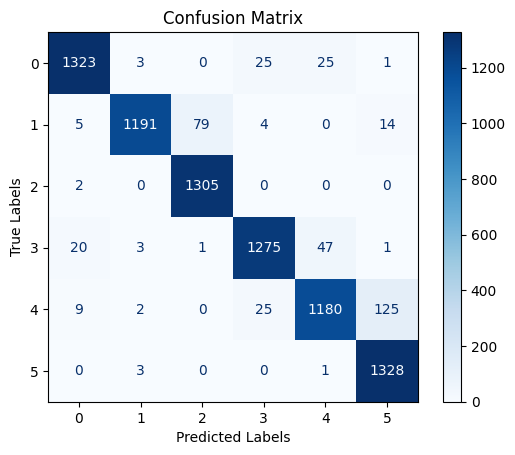

In [15]:
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for input_ids, attention_masks, labels in eval_dataloader:
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()


**Modeli tahmin etme ve Modeli kaydetme :**
1. Fine tune ettiğimiz model üzerinden tahmin işlemi yapıyoruz.
2. Modeli kaydediyoruz.
3. Modelin kaydolduğunu yazdırıyoruz.

In [16]:
def predict_sentence(model, sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    return preds.cpu().item() 

sentence = "Despite trying my best to stay positive, everything around me feels heavy and overwhelming, leaving me with a deep sense of sadness"
predicted_label = predict_sentence(model, sentence)
print(model.config.id2label[predicted_label])



üzgün


In [17]:
save_directory = "./bert_finetuned_model_2"
os.makedirs(save_directory, exist_ok=True)

model.save_pretrained(save_directory)
tokenizer = tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
tokenizer.save_pretrained(save_directory)

print(f"Model ve tokenizer {save_directory} dizinine kaydedildi.")


Model ve tokenizer ./bert_finetuned_model_2 dizinine kaydedildi.


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
shutil.move(save_directory, "/kaggle/working/bert_finetuned_model_2")

print("Model /kaggle/working/bert_finetuned_model_2 dizinine taşındı.")


Model /kaggle/working/bert_finetuned_model_2 dizinine taşındı.


In [19]:
load_directory = "/kaggle/working/bert_finetuned_model_2"
modelsave = AutoModelForSequenceClassification.from_pretrained(load_directory)
tokenizersave = AutoTokenizer.from_pretrained(load_directory)

print("Model ve tokenizer başarıyla yüklendi.")


Model ve tokenizer başarıyla yüklendi.
